# **Fase exploratória**

In [1]:
import umap
import sys
import os
sys.path.append(os.path.abspath("../../.."))

import pickle
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
import numpy as np
import pandas as pd
import plotly.express as px
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, GroupShuffleSplit

from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler
from scipy.linalg import LinAlgError

from core.split_samples import get_splited_data

from sklearn.utils import resample

import matplotlib.pyplot as plt

from scipy.stats import f_oneway

#         **Exploratory Analysis**

## **Etapa 1: Análise Inicial e Preparação**

- Dados a Utilizar: DataFrame Total.
- Objetivo Principal: Garantir a saúde, integridade e o entendimento básico dos dados brutos antes de qualquer divisão.


### 1.1 Carregando os dados

In [2]:
data = pd.read_excel(
    '../../../datasets/base_vertical/intermediate/new_HS_agregado_codificado_20windows_Binary.xlsx')
data = data.drop(columns=['window_id'])

### 1.2 Inspeção Estrutural
Verificar o número de linhas, colunas, e os tipos de dados de cada coluna. Procurar por colunas que deveriam ser numéricas mas estão como object (texto).

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Columns: 107 entries, Heart Sound ID to Location_RUSB
dtypes: float64(84), int64(22), object(1)
memory usage: 836.1+ KB


### 1.3 Análise Descritiva

Calcular estatísticas básicas (média, desvio padrão, mínimo, máximo, quartis) para todas as colunas numéricas. Isso ajuda a identificar escalas muito diferentes entre as features, o que confirma a necessidade de normalização mais tarde.

In [4]:
data.describe()

,freq_mean,centro_x_mean,centro_y_mean,raio_medio_mean,raio_std_mean,raio_max_mean,raio_min_mean,simetria_x_mean,simetria_y_mean,densidade_nucleo_mean,...,Gender_F,Gender_M,Heart Sound Type_Abnormal,Heart Sound Type_Normal,Location_Apex,Location_LC,Location_LLSB,Location_LUSB,Location_RC,Location_RUSB
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.00000,1000.00000,1000.00000,1000.00000,1000.0000,1000.000000,1000.0000,1000.000000,1000.000000,1000.000000
mean,87.975950,-0.000003,0.000018,0.063181,0.071692,0.569230,0.000579,0.063494,0.063370,0.805164,...,0.52000,0.48000,0.82000,0.18000,0.2000,0.120000,0.2000,0.260000,0.080000,0.140000
std,40.751907,0.000662,0.000701,0.029244,0.030738,0.246323,0.000314,0.028474,0.028426,0.124036,...,0.49985,0.49985,0.38438,0.38438,0.4002,0.325124,0.4002,0.438854,0.271429,0.347161
min,37.388393,-0.004336,-0.008351,0.003794,0.003912,0.026273,0.000028,0.003743,0.003751,0.424573,...,0.00000,0.00000,0.00000,0.00000,0.0000,0.000000,0.0000,0.000000,0.000000,0.000000
25%,60.219029,-0.000223,-0.000174,0.042708,0.046633,0.393610,0.000349,0.043283,0.043255,0.719514,...,0.00000,0.00000,1.00000,0.00000,0.0000,0.000000,0.0000,0.000000,0.000000,0.000000
50%,72.247606,-0.000015,0.000014,0.059482,0.070563,0.555946,0.000524,0.060696,0.060472,0.844127,...,1.00000,0.00000,1.00000,0.00000,0.0000,0.000000,0.0000,0.000000,0.000000,0.000000
75%,104.067251,0.000211,0.000240,0.076862,0.094004,0.768914,0.000721,0.078053,0.077924,0.904163,...,1.00000,1.00000,1.00000,0.00000,0.0000,0.000000,0.0000,1.000000,0.000000,0.000000
max,244.020833,0.005114,0.004882,0.198082,0.154161,1.008667,0.002448,0.190775,0.190229,0.989322,...,1.00000,1.00000,1.00000,1.00000,1.0000,1.000000,1.0000,1.000000,1.000000,1.000000


### 1.4 Verificação de nulos
Saber quantos valores ausentes (NaN) existem em cada coluna.

In [5]:
data.isnull().sum()

Heart Sound ID     0
freq_mean          0
centro_x_mean      0
centro_y_mean      0
raio_medio_mean    0
                  ..
Location_LC        0
Location_LLSB      0
Location_LUSB      0
Location_RC        0
Location_RUSB      0
Length: 107, dtype: int64

### 1.5 Análise da Variável Alvo

Precisamos verificar a proporção das classes (quantos 'Normais' vs. 'Anormais'). Isso é crucial para saber se  o dataset é desbalanceado.

In [6]:
print(data['Heart Sound Type_Abnormal'].value_counts(normalize=True))


Heart Sound Type_Abnormal
1    0.82
0    0.18
Name: proportion, dtype: float64


Lidando com o desbalanceamento da base de dados: aqui poderemos gerar um subconjunto onde o número de casos de normalidade é igual ao número de casos normais, apenas para fins de visualização e comparação. Posteriormente teremos que lidar com esse desbalanceamento de forma mais estruturada.

| Etapa                     | Como vamos lidar com o desbalanceamento?                                                                                       | Exemplo prático                                      |
| ------------------------- | ------------------------------------------------------------------------------------------------------------------------ | ---------------------------------------------------- |
| **1. Exploração**         | 🔸 *Usar subconjuntos balanceados* só para visualizações (opcional)                                                      | PCA, UMAP com 140 normais + 140 anormais             |
| **2. Pré-processamento**  | 🔸 Pode aplicar **undersampling/oversampling** e salvar base balanceada (opcional)                                       | Criar dataset balanceado para um experimento isolado |
| **3. Modelagem**          | ✓ Aqui sim é **onde realmente importa mais**:<br>• usar `class_weight='balanced'`<br>• ou aplicar SMOTE/undersample aqui | RandomForest, SVM, XGBoost, redes                    |
| **4. Validação**          | ✓ Sempre avaliar com **métricas robustas** (`recall`, `F1`, `AUC`) e **fazer isso nos dados originais (desbalanceados)** | Para refletir realidade clínica                      |
| **5. Apresentação final** | ✓ Testar modelo final em base **original não balanceada**, reportando sensibilidade, precisão, curva ROC etc.            | Para garantir validade científica ou clínica         |


## **Etapa 2: Separação dos Dados** 

Criar as partições de treino e teste, isolando o conjunto de teste para garantir uma avaliação final 100% imparcial.

### 2.1 Definir _features_ (X) e alvo (y)

Aqui precisaremos tomar cuidado com o vazamento de dados por agrupamento (_data leakage due to grouping_). Se uma janela dde um determinado áudio está no treino e outra do mesmo áudio está no teste, o modelo "trapaceia". Ele aprende sobre o determinado áudio no treino e depois é testado em um dado muito similar (outra janela do mesmo áudio), o que leva a uma performance artificialmente alta e a um otimismo irrealista.

Portanto, deve-se pensar em uma divisão baseada em grupos.
A solução é garantir que a unidade de separação não seja a janela (a linha do dataframe), mas sim o áudio de origem (o grupo). Todas as 20 janelas de um determinado áudio devem pertencer juntas ao conjunto de treino ou juntas ao conjunto de teste. Nunca separadas.

O Scikit-learn tem ferramentas específicas para isso. As principais são `GroupShuffleSplit` e `GroupKFold`.

In [7]:
X, y = get_splited_data(data, 'Heart Sound Type_Abnormal')

### 2.2 Executar a Divisão

In [11]:
groups = X['Heart Sound ID']

gss = GroupShuffleSplit(n_splits=1, test_size=0.15, random_state=42)

""" 
O .split() gera os ÍNDICES de treino e teste.
Precisamos usá-lo com next() porque ele é um gerador.
"""
train_idx, test_idx = next(gss.split(X, y, groups=groups))

# usando os índices para criar os df's
X_train = X.iloc[train_idx]
X_test = X.iloc[test_idx]

y_train = y.iloc[train_idx]
y_test = y.iloc[test_idx]

groups_train = groups.iloc[train_idx]

Verificação: é importante verificar que não há nenhum _Heart Sound ID_ que apareça tanto em `X_train` quanto em `X_test`.

In [118]:
print(f"Audios no treino: {len(X_train['Heart Sound ID'].unique())}")
print(f"Audios no teste: {len(X_test['Heart Sound ID'].unique())}")

train_audios = set(X_train['Heart Sound ID'].unique())
test_audios = set(X_test['Heart Sound ID'].unique())
print("Audios vazados (interseção):", train_audios.intersection(
    test_audios))  # <===== Deve ser um conjunto vazio!

Audios no treino: 42
Audios no teste: 8
Audios vazados (interseção): set()


In [ ]:
# X_test.to_csv('../../../datasets/base_vertical/processed/X_test.csv', index=False)
# X_train.to_csv(
#     '../../../datasets/base_vertical/processed/X_train.csv', index=False)
# y_test.to_csv(
#     '../../../datasets/base_vertical/processed/y_test.csv', index=False)
# y_train.to_csv(
#     '../../../datasets/base_vertical/processed/y_train.csv', index=False)

### 2.3 Salvando os dados por segurança

In [12]:
X_train = X_train.drop(columns=['Heart Sound ID', 'Heart Sound Type_Normal'])
X_test = X_test.drop(columns=['Heart Sound ID', 'Heart Sound Type_Normal'])

In [13]:

data_to_save = {
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test': y_test
}
with open('../../../datasets/base_vertical/processed/train_test_sets.pkl', 'wb') as f:
    pickle.dump(data_to_save, f)


""" 
Para carregar os dados:

with open('../../../datasets/base_vertical/processed/train_test_sets.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

X_train_ = loaded_data['X_train']
X_test_ = loaded_data['X_test']
y_train_ = loaded_data['y_train']
y_test_ = loaded_data['y_test']
"""

" \nPara carregar os dados:\n\nwith open('../../../datasets/base_vertical/processed/train_test_sets.pkl', 'rb') as f:\n    loaded_data = pickle.load(f)\n\nX_train_ = loaded_data['X_train']\nX_test_ = loaded_data['X_test']\ny_train_ = loaded_data['y_train']\ny_test_ = loaded_data['y_test']\n"

In [14]:
del data['Heart Sound ID']

In [15]:
X_train

,freq_mean,centro_x_mean,centro_y_mean,raio_medio_mean,raio_std_mean,raio_max_mean,raio_min_mean,simetria_x_mean,simetria_y_mean,densidade_nucleo_mean,...,autocorr_lag_3,has_trapping,Gender_F,Gender_M,Location_Apex,Location_LC,Location_LLSB,Location_LUSB,Location_RC,Location_RUSB
0,164.354167,-0.000004,0.000024,0.030488,0.029553,0.221206,0.000223,0.029517,0.029474,0.785000,...,1.356208,1,1,0,1,0,0,0,0,0
1,165.967851,-0.000125,0.000078,0.029203,0.027863,0.197124,0.000237,0.029405,0.029447,0.763570,...,2.107014,1,1,0,1,0,0,0,0,0
2,134.653533,0.000016,0.000108,0.039275,0.039114,0.466807,0.000273,0.038954,0.038890,0.913016,...,2.675314,0,1,0,1,0,0,0,0,0
3,128.112793,-0.000062,-0.000403,0.042433,0.039972,0.466564,0.000424,0.040655,0.040692,0.902168,...,3.471016,1,1,0,1,0,0,0,0,0
4,148.798077,-0.000023,-0.000161,0.050374,0.046386,0.466689,0.000442,0.048990,0.049270,0.860346,...,4.349346,1,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,72.182513,-0.000078,-0.000060,0.074462,0.100202,0.706487,0.000553,0.074324,0.073912,0.855199,...,-15.944416,1,0,1,0,0,0,1,0,0
996,84.000000,-0.000307,-0.000269,0.089283,0.124158,0.705161,0.000713,0.096586,0.095843,0.814325,...,-24.181261,1,0,1,0,0,0,1,0,0
997,94.170673,-0.003138,0.004882,0.101705,0.141314,0.702215,0.000741,0.101515,0.101581,0.789976,...,-32.354565,1,0,1,0,0,0,1,0,0
998,89.746094,0.000609,-0.003273,0.102482,0.143831,0.699830,0.000990,0.109614,0.113552,0.792266,...,-34.234081,1,0,1,0,0,0,1,0,0


##### Mas e quanto aos dados de validação?

Muitas vezes nos perguntamos sobre a separação dos **dados de validação**. 

A Validação Cruzada (Cross-Validation), que implementamos com `StratifiedKFold` e `cross_val_score` / `GridSearchCV`, já cumpre o papel do conjunto de validação de uma forma muito mais sólida e eficiente do que uma separação manual.

Por que precisamos de validação? O conjunto de validação tem dois objetivos principais:

- Ajuste de Hiperparâmetros: Encontrar os melhores parâmetros para um modelo (ex: qual o melhor max_depth para uma árvore de decisão?) sem usar o conjunto de teste.
- Seleção de Modelos: Decidir qual modelo é melhor (ex: Random Forest se sai melhor que MLP?) sem usar o conjunto de teste.

Se usássemos o conjunto de teste para isso, estaríamos "vazando" informação do teste para o nosso processo de decisão, e a avaliação final não seria mais imparcial.

As duas maneiras de se ter um conjunto de validação são:

**Abordagem 1: A Divisão Tripla (Train / Validation / Test)**

Nesta abordagem,  divide-se manualmente seus dados em três partes:
1. Conjunto de Treino (ex: 60%): Usado para treinar o modelo com um conjunto de hiperparâmetros.
2. Conjunto de Validação (ex: 20%): Usado para avaliar o modelo treinado e decidir se os hiperparâmetros são bons. Você repete o treino e a validação até encontrar os melhores parâmetros.
3. Conjunto de Teste (ex: 20%): Usado uma única vez no final, com o modelo final e os melhores hiperparâmetros, para obter a métrica de performance final.

- Quando é usada? Principalmente com datasets muito grandes (milhões de registros), onde treinar o modelo várias vezes (como na validação cruzada) é computacionalmente inviável. É a abordagem padrão em Deep Learning, onde monitora-se a performance no conjunto de validação a cada época de treinamento.

- Desvantagens (especialmente para o seu caso):

     - Desperdício de Dados: Com um dataset de ~1000 registros como o seu, separar 20% para validação significa que você está abrindo mão de 200 amostras que poderiam ser usadas para treinar melhor o seu modelo.
     - Menos Confiável: A performance no conjunto de validação pode depender muito da "sorte" de quais amostras caíram ali. Se, por acaso, algumas amostras difíceis ou fáceis demais caem todas na validação, a estimativa de performance será enviesada.

**Abordagem 2: Divisão Dupla + Validação Cruzada (A que será usada neste projeto)**     

Faz-se apenas uma divisão:

- Conjunto de Treino (ex: 80%): Este é o o universo de trabalho.
- Conjunto de Teste (ex: 20%): Fica trancado até o final.

E onde entra a validação? Ela acontece dinamicamente dentro do conjunto de treino. É exatamente isso que o `StratifiedKFold` faz.

A Validação Cruzada de 5 folds (K=5) funciona da seguinte forma:

Ela pega o `X_train` e o divide em 5 pedaços (folds).
- Rodada 1: Treina o modelo nos pedaços 2, 3, 4 e 5. Usa o pedaço 1 como validação.
- Rodada 2: Treina o modelo nos pedaços 1, 3, 4 e 5. Usa o pedaço 2 como validação.
- Rodada 3: Treina o modelo nos pedaços 1, 2, 4 e 5. Usa o pedaço 3 como validação.
...e assim por diante.

O `cross_val_score` ou `GridSearchCV` faz tudo isso automaticamente. A performance final da validação é a média das performances em cada uma das 5 rodadas.

Quando é usada? É o padrão-ouro para a maioria dos projetos de Machine Learning, especialmente com datasets que não são gigantescos (de centenas até centenas de milhares de registros).

- Vantagens:

     - Uso Eficiente dos Dados: Todas as amostras do conjunto de treino são usadas tanto para treinar quanto para validar em algum momento. Nada é desperdiçado.
     - Muito Mais performática: Como a performance é a média de várias rodadas, o resultado é muito mais estável e confiável do que uma única divisão de validação.

## **Etapa 3: Análise Exploratória Profunda (EDA)**

Dados a utilizar: `X_train` e `y_train`
Aqui deve-se investigar as relações entre asfeatures e a variável alvo para gerar hipóteses e guiar a modelagem.

### 3.1 Análise de Correlação entre as _features_:
- Criar uma matriz de correlação para ver quais _features_ estão fortemente relacionadas entre si. _Features_ com correlação muito alta (ex: >0.9 ou < -0.9>) são redundantes e pode-se considerar remover uma delas.
- Ferramenta: `X_train.corr()`, `seaborn.heatmap(X_train.corr())`

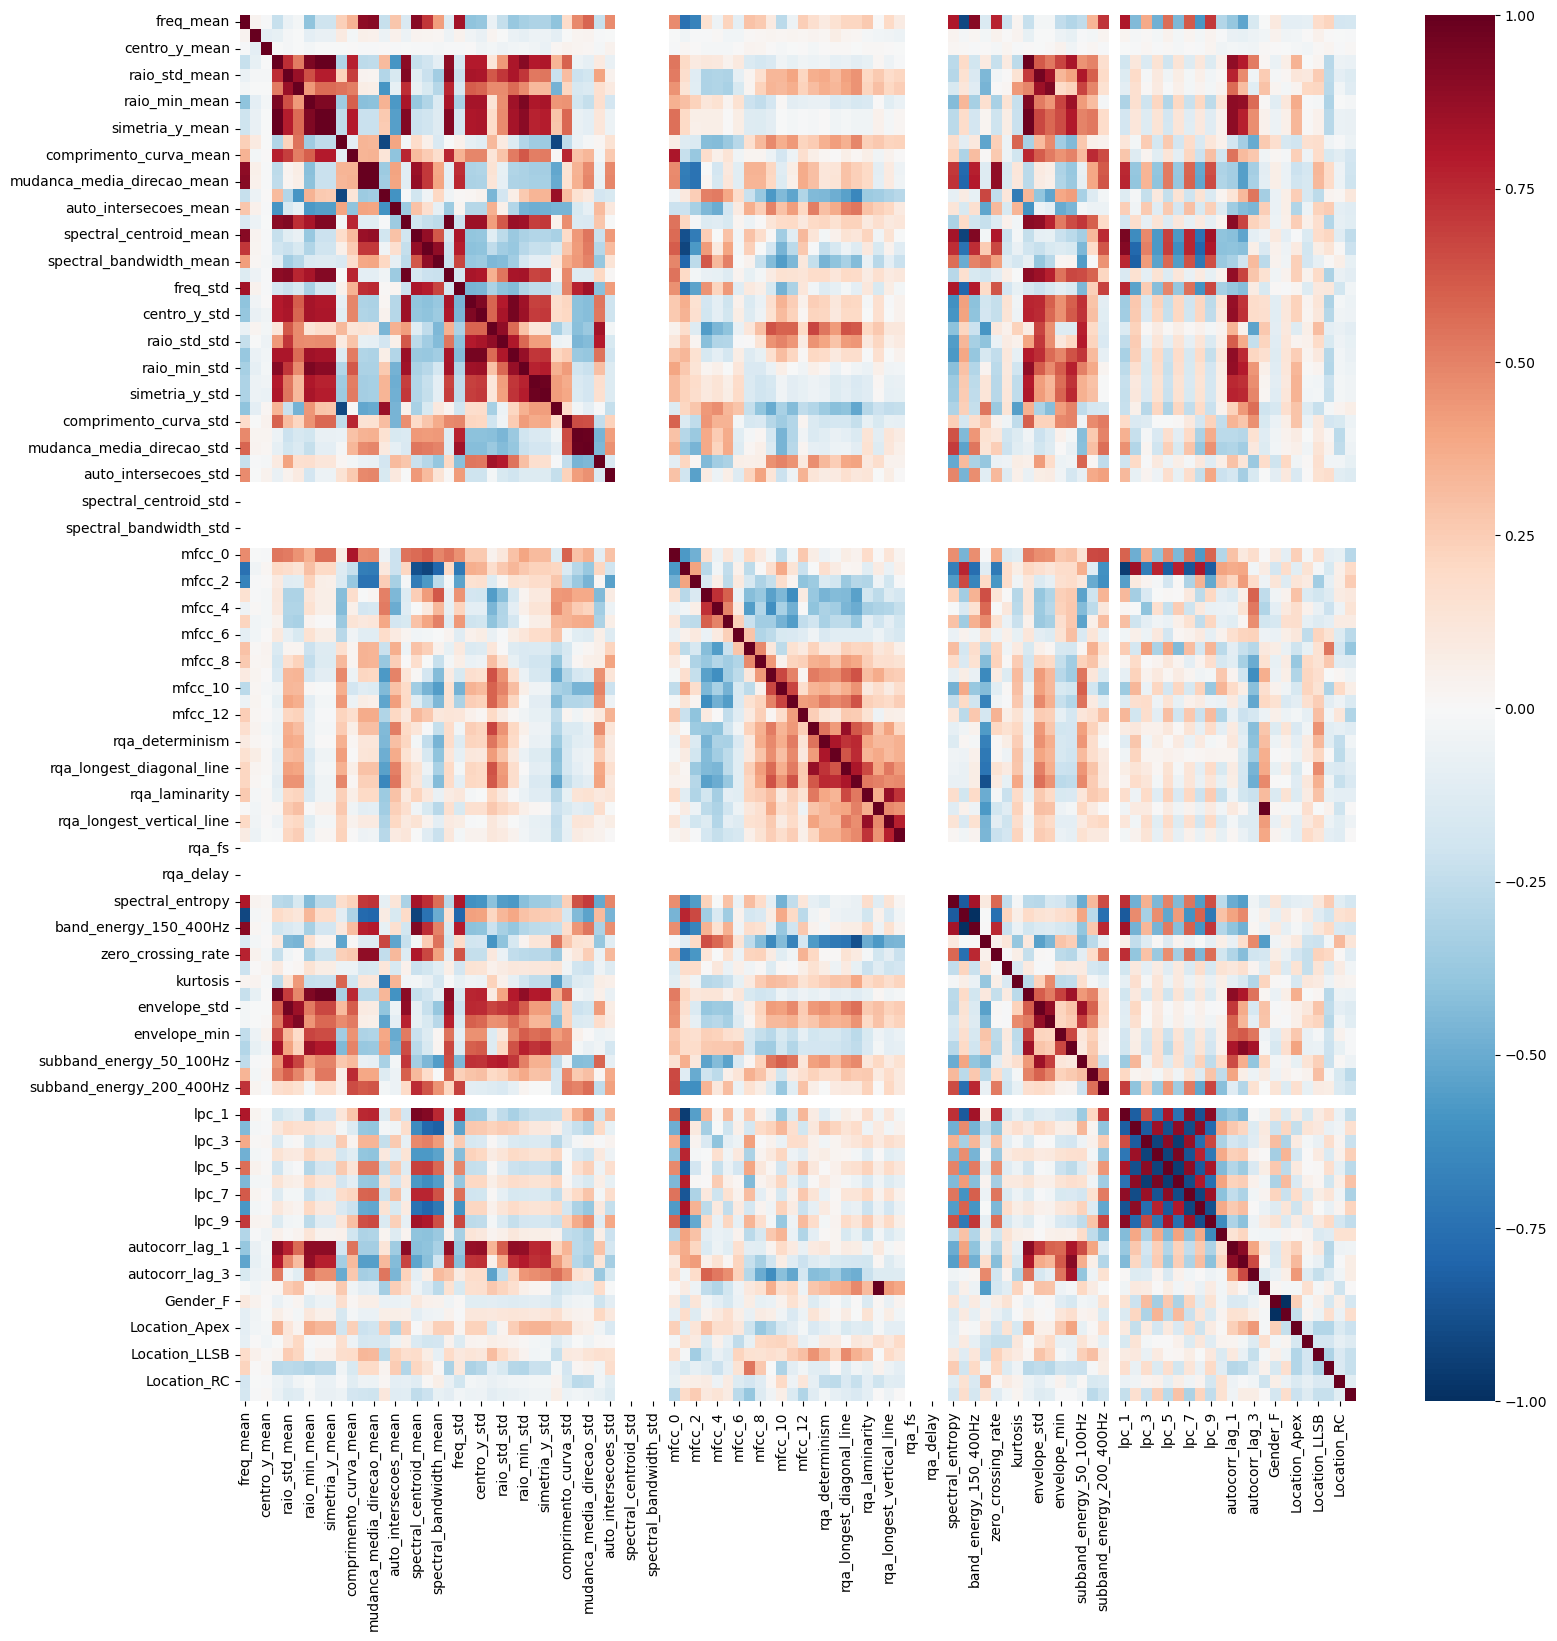

In [16]:

fig, ax = plt.subplots(figsize=(18,18))

ax = sns.heatmap(X_train.corr(),
             fmt='.2f',
             ax=ax,
             cmap="RdBu_r",
             vmin=-1,
             vmax=1,)
#sns.heatmap(X_train.corr())

O heatmap mostra claramente a existência de multicolinearidade, ou seja, grupos de features que estão fortemente correlacionadas entre si.

Manter features altamente correlacionadas é problemático por algumas razões:

- Redundância: O modelo não aprende nada de novo. Se duas features são 95% correlacionadas, elas estão essencialmente dizendo a mesma coisa.
- Instabilidade do Modelo: Alguns algoritmos (como regressões lineares) podem se tornar instáveis. Modelos de árvore (como o Random Forest) são mais robustos a isso, mas a redundância pode enviesar a interpretação da "importância das features".
- Maldição da Dimensionalidade: Manter features desnecessárias aumenta a complexidade do problema sem adicionar informação útil, podendo até piorar a performance do modelo.



In [17]:

from sklearn.feature_selection import mutual_info_classif

corr_matrix = X_train.corr().abs()
upper_triangle = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

mi_scores = mutual_info_classif(X_train, y_train, random_state=42)
mi_series = pd.Series(mi_scores, index=X_train.columns)

threshold = 0.85
to_drop = []

for col in upper_triangle.columns:
    for row in upper_triangle.index:
        if upper_triangle.loc[row, col] > threshold:
            # Comparar importâncias: dropa a menos relevante
            if mi_series[row] < mi_series[col]:
                to_drop.append(row)
            else:
                to_drop.append(col)

to_drop = list(set(to_drop))

X_train_reduced = X_train.drop(columns=to_drop)
#X_test_reduced = X_test.drop(columns=to_drop)

print(
    f"Número de features removidas com critério de utilidade: {len(to_drop)}")
print("Features removidas:", to_drop)

Número de features removidas com critério de utilidade: 41
Features removidas: ['spectral_flux_mean', 'simetria_y_std', 'lpc_9', 'freq_mean', 'envelope_std', 'spectral_rolloff_mean', 'mfcc_1', 'simetria_y_mean', 'raio_std_std', 'mudanca_media_direcao_mean', 'spectral_bandwidth_mean', 'rms_energy_mean', 'lpc_2', 'raio_max_std', 'raio_std_mean', 'raio_medio_mean', 'raio_min_mean', 'has_trapping', 'lpc_7', 'raio_max_mean', 'variacao_curvatura_mean', 'densidade_nucleo_mean', 'rqa_entropy_diagonal_lines', 'lpc_5', 'rqa_longest_diagonal_line', 'rqa_laminarity', 'autocorr_lag_1', 'entropia_raio_mean', 'variacao_curvatura_std', 'band_energy_150_400Hz', 'centro_x_std', 'lpc_8', 'centro_y_std', 'Gender_M', 'spectral_centroid_mean', 'subband_energy_0_50Hz', 'lpc_4', 'simetria_x_mean', 'envelope_mean', 'lpc_6', 'raio_min_std']


<Axes: >

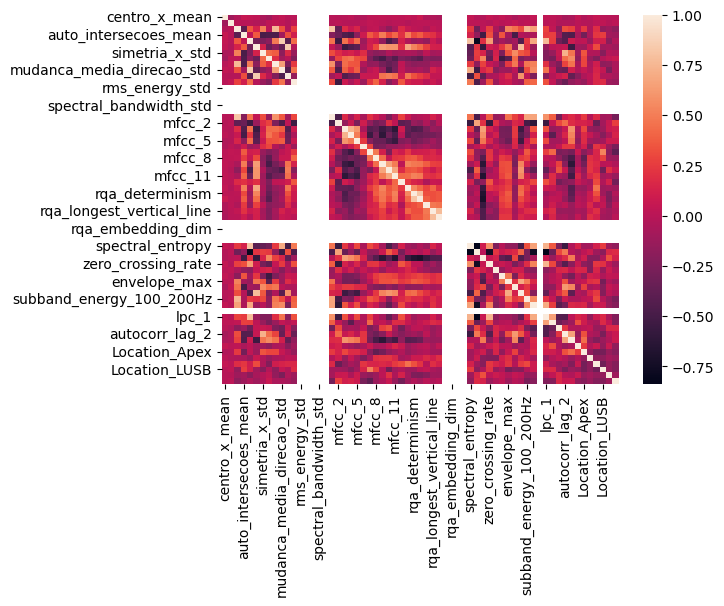

In [18]:
sns.heatmap(X_train_reduced.corr())

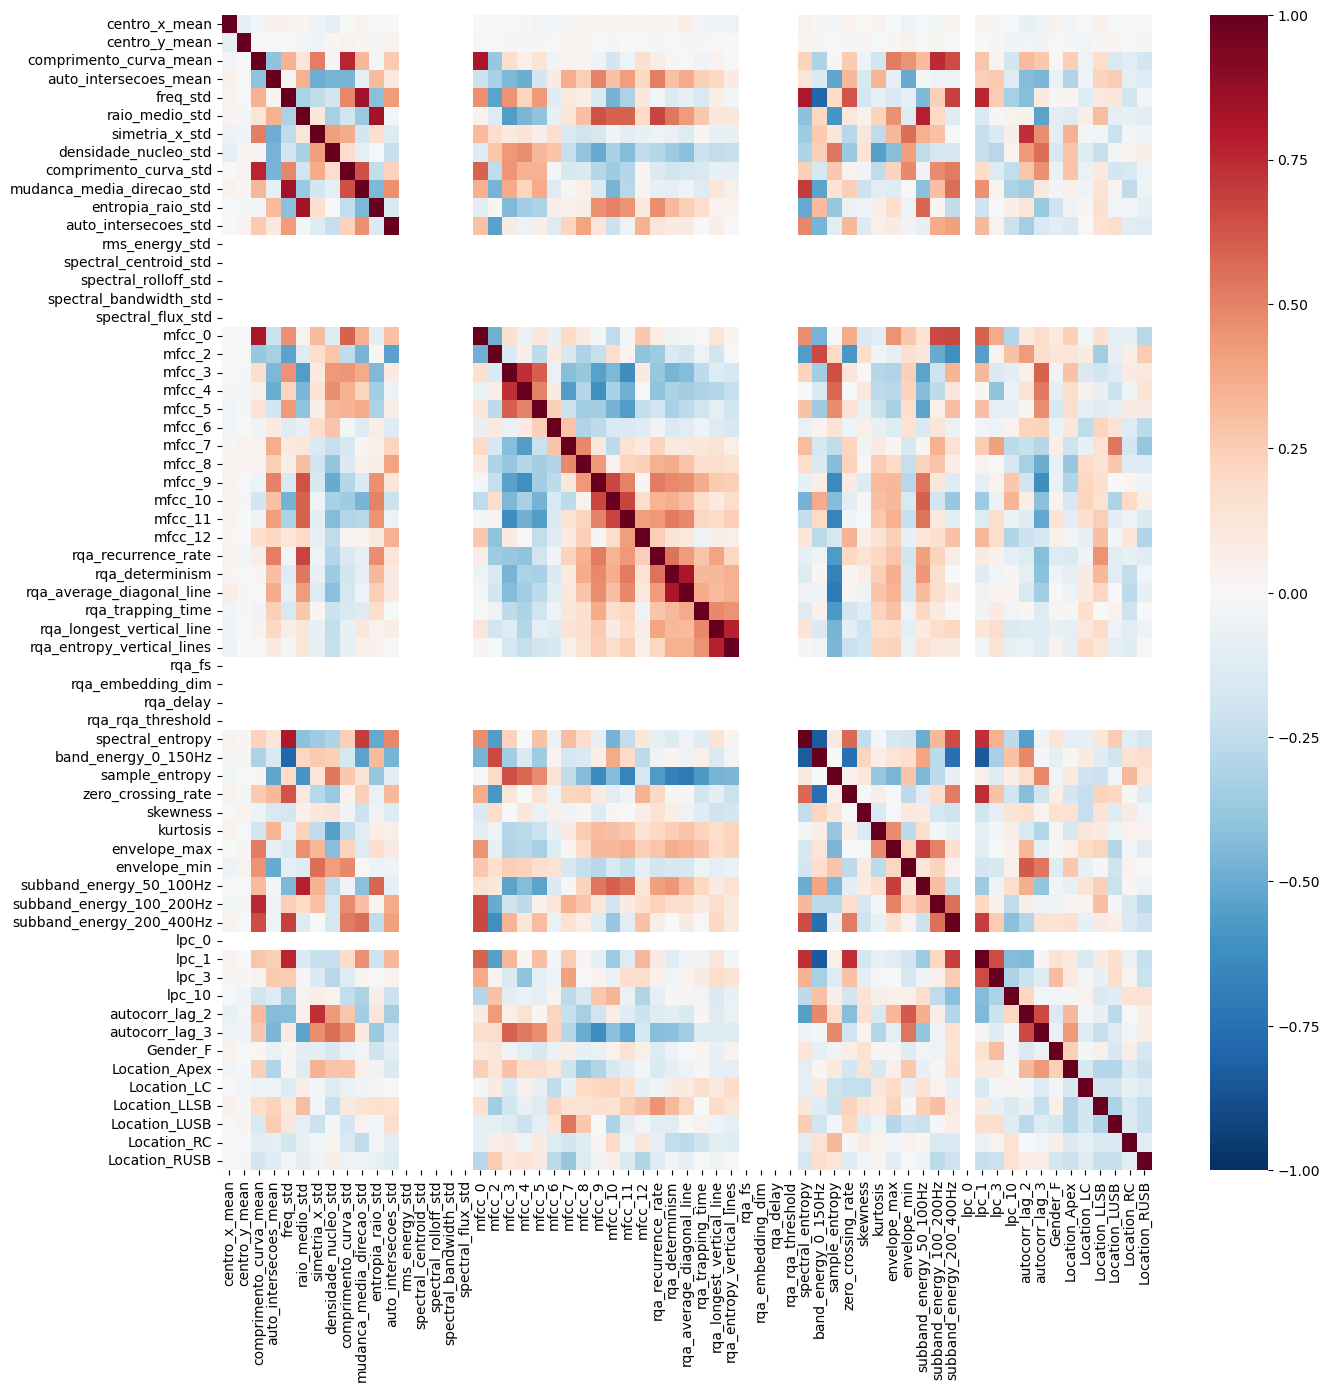

In [19]:

fig, ax = plt.subplots(figsize=(15, 15))

ax = sns.heatmap(X_train_reduced.corr(),
                 fmt='.2f',
                 ax=ax,
                 cmap="RdBu_r",
                 vmin=-1,
                 vmax=1,)
# sns.heatmap(X_train.corr())

In [78]:
# """ Correlograma das 30 principais"""
# top_vars = X_train_reduced.columns[:30].tolist()

# corr = X_train_reduced[top_vars].corr()

# plt.figure(figsize=(20, 10))


# sns.heatmap(corr, cmap='coolwarm', annot=True, fmt=".2f", square=True)


# plt.title("Correlograma das 30 Variáveis com Maior Desvio Padrão")


# plt.tight_layout()


# plt.show()

### 3.2 Visualização da Distribuição por Classe

Para as features mais promissoras, é interessante criar gráficos que mostrem a distribuição dos valores para a classe Normal vs. Anormal. Se as distribuições forem bem diferentes, a feature é um bom preditor.

AVISO: Não foi possível calcular o KDE para 'rms_energy_std'. Gerando novamente sem KDE.
AVISO: Não foi possível calcular o KDE para 'spectral_centroid_std'. Gerando novamente sem KDE.
AVISO: Não foi possível calcular o KDE para 'spectral_rolloff_std'. Gerando novamente sem KDE.
AVISO: Não foi possível calcular o KDE para 'spectral_bandwidth_std'. Gerando novamente sem KDE.
AVISO: Não foi possível calcular o KDE para 'spectral_flux_std'. Gerando novamente sem KDE.
AVISO: Não foi possível calcular o KDE para 'rqa_delay'. Gerando novamente sem KDE.
AVISO: Não foi possível calcular o KDE para 'lpc_0'. Gerando novamente sem KDE.


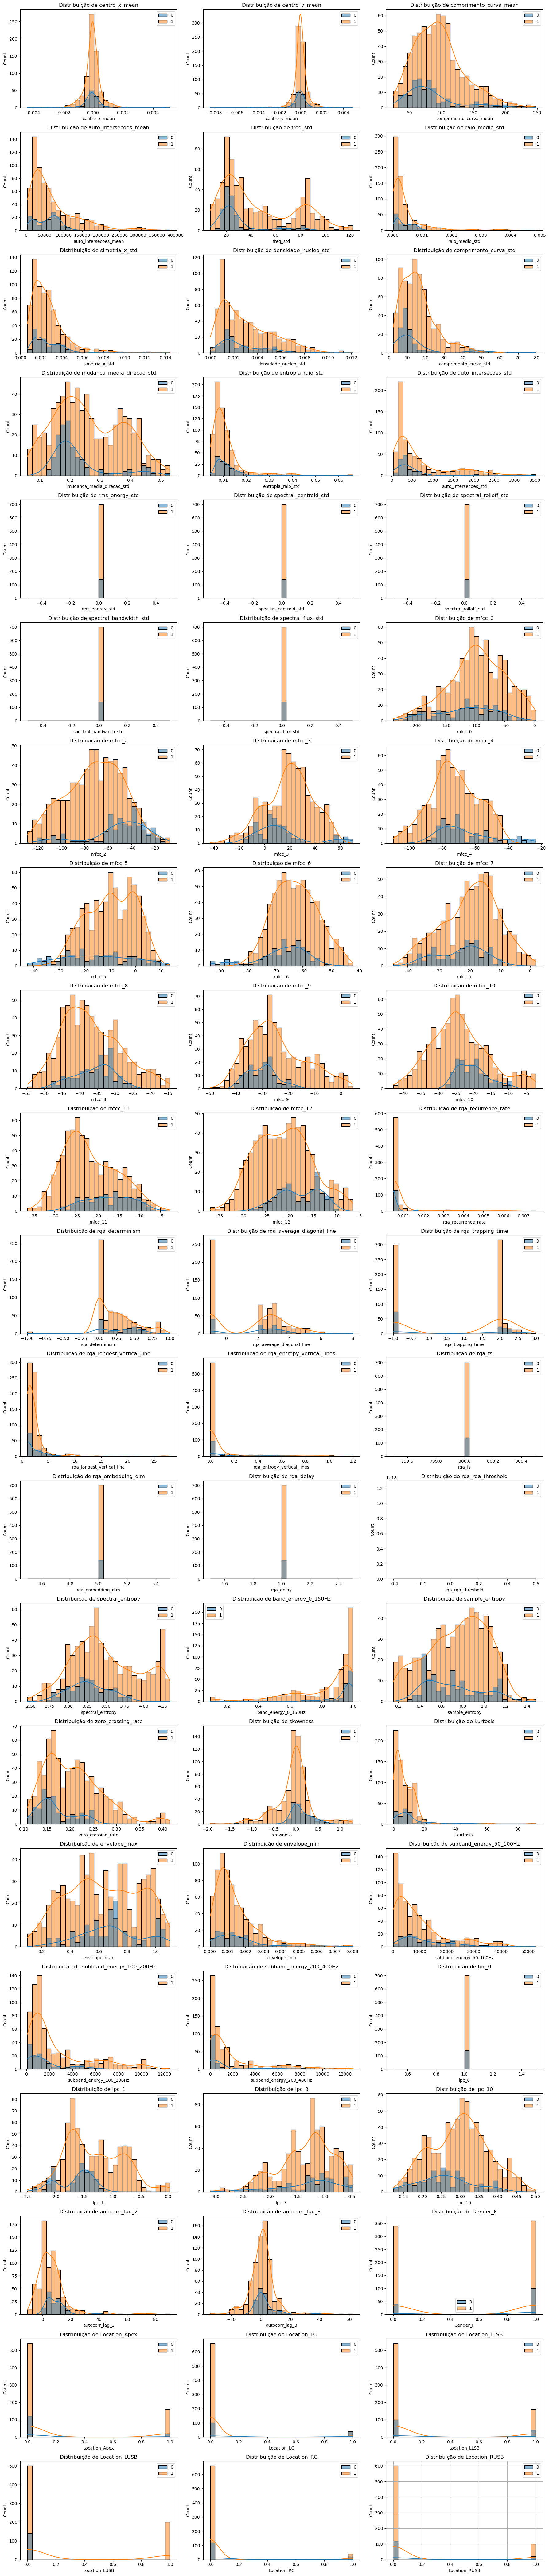

In [21]:

import math  

plot_df = X_train_reduced.join(y_train)
target_column_name = y_train.name

numeric_cols = X_train_reduced.select_dtypes(include=np.number).columns
n_features = len(numeric_cols)

ncols = 3  
nrows = math.ceil(n_features / ncols) 

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         figsize=(ncols * 6, nrows * 4))

axes = axes.flatten()

for i, column in enumerate(numeric_cols):
    ax = axes[i]  

    try:
        sns.histplot(data=plot_df, x=column,
                     hue=target_column_name, kde=True, bins=30, ax=ax)
    except LinAlgError:
        print(f"AVISO: Não foi possível calcular o KDE para '{column}'. Gerando novamente sem KDE.")
        sns.histplot(data=plot_df, x=column,
                     hue=target_column_name, kde=False, bins=30, ax=ax)

    ax.set_title(f'Distribuição de {column}', fontsize=12)
    ax.legend_.set_title(None)  

for i in range(n_features, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.grid(True)
plt.show()

Analisando e deletando as _features_ contínuas de valores constantes, pois não apresentam qualquer variabilidade.

In [22]:
cols_constantes = [
    col for col in X_train_reduced.columns if X_train_reduced[col].nunique() == 1]

print("Colunas com valor constante:", cols_constantes)

X_train_reduced = X_train_reduced.drop(columns=cols_constantes, errors='ignore')

Colunas com valor constante: ['rms_energy_std', 'spectral_centroid_std', 'spectral_rolloff_std', 'spectral_bandwidth_std', 'spectral_flux_std', 'rqa_fs', 'rqa_embedding_dim', 'rqa_delay', 'rqa_rqa_threshold', 'lpc_0']


#### 3.3 Mutual Information

Medir quanto de informação uma feature contém sobre o rótulo (target), seja linear, não-linear, monotônica ou não.

Natureza: medida não-paramétrica de dependência estatística entre duas variáveis.

Interpretação:

- MI(X, Y) = 0 ⟺ X e Y são estatisticamente independentes.
- MI(X, Y) > 0 ⟺ há alguma relação informativa entre X e Y, linear ou não.

Estimamos o grau de dependência.

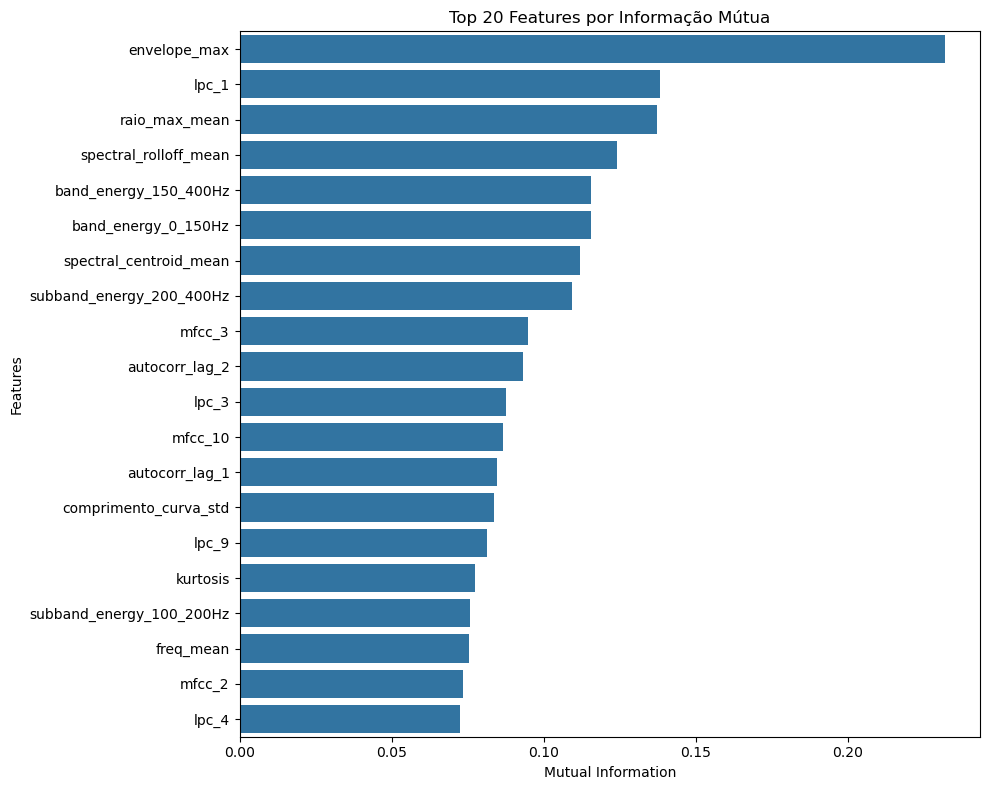

In [28]:

mi_scores = mutual_info_classif(X_train, y_train, random_state=42)
mi_series = pd.Series(mi_scores, index=X_train.columns, name="MI Score")
mi_series = mi_series.sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x=mi_series.head(20), y=mi_series.head(20).index)
plt.title("Top 20 Features por Informação Mútua")
plt.xlabel("Mutual Information")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

### 3.4 Análise de Dimensionalidade

O objetivo é reduzir o número de dimensões para 2D ou 3D, preservando a estrutura de variabilidade dos dados, para:

- Visualizar separabilidade entre classes;
- Identificar clusters ou sobreposições;
- Detectar ruído ou _outliers_.

**Métodos**:

- **PCA (Principal Component Analysis)**
     - Linear: projeta os dados nos eixos que explicam mais variância.
     - Bom para compressão, interpretação e explicação.

- t-SNE (t-distributed Stochastic Neighbor Embedding)
     - Não linear, baseado em proximidade local entre pontos.
     - Excelente para visualização em 2D, mas não para modelagem nem generalização.



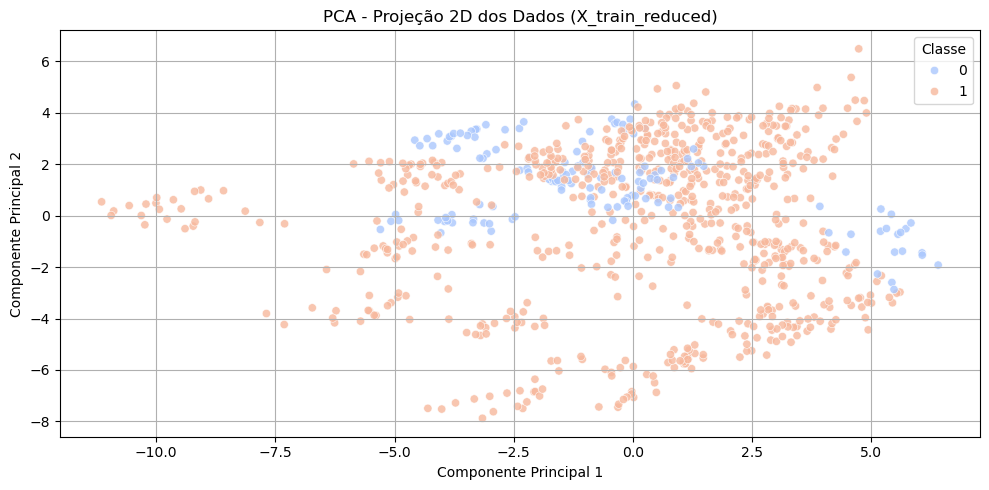

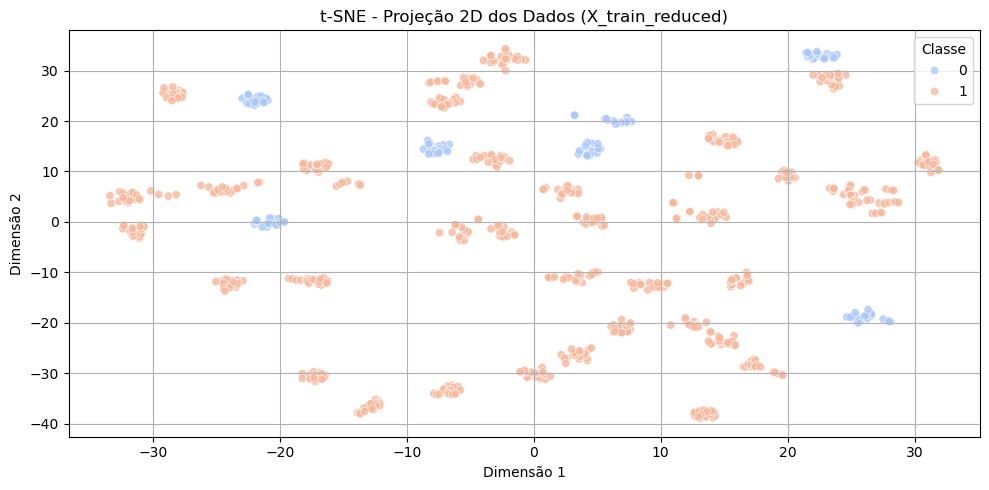

In [ ]:


scaler = StandardScaler()  # Normalizando primeiro
X_scaled = scaler.fit_transform(X_train_reduced)

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200)
X_tsne = tsne.fit_transform(X_scaled)

df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
df_pca["Classe"] = y_train.values

df_tsne = pd.DataFrame(X_tsne, columns=["Dim1", "Dim2"])
df_tsne["Classe"] = y_train.values

plt.figure(figsize=(10, 5))
sns.scatterplot(data=df_pca, x="PC1", y="PC2",
                hue="Classe", palette="coolwarm", alpha=0.8)
plt.title("PCA - Projeção 2D dos Dados (X_train_reduced)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.scatterplot(data=df_tsne, x="Dim1", y="Dim2",
                hue="Classe", palette="coolwarm", alpha=0.8)
plt.title("t-SNE - Projeção 2D dos Dados (X_train_reduced)")
plt.xlabel("Dimensão 1")
plt.ylabel("Dimensão 2")
plt.grid(True)
plt.tight_layout()
plt.show()